**DSCI 100 GROUP PROPOSAL:  
A CLASSIFICATION MODEL TO DETECT PHISHING WEBSITES**

**INTRODUCTION:**  
The term phishing is defined as the fraudulent attempt to obtain sensitive information such as usernames, passwords and credit card details by disguising oneself as a trustworthy entity in an electronic communication. The purpose of a phishing website is to steal personal information or other confidential information by tricking the victim into believing that the website is legitimate. 

We want to answer the question: how accurately could a statistical classifier predict if a website was a legitimate service, a phishing scam, or somewhere in between, based on several variables? By making a classifier this way, we can find out if some features are more common and specific to the phishing websites than legitimate ones, or conversely if there are there features that are falsely associated with phishing websites. 

The large data set that we are using was obtained from a machine learning database: https://archive.ics.uci.edu/ml/machine-learning-databases/00327/  
and contains information about the features that are commonly associated with phishing websites, such as unsecure ports, text in pop-up windows, etc. These features are usually evaluated while making a model that distinguishes between legitimate and phishing websites. For a more specific description of each variable we are looking at, see PRELIMINARY ANALYSIS.


**PRELIMINARY EXPLORATORY DATA ANALYSIS:  
Here we read in the data from the web and interpret the dataset's columns.**

In [1]:
# Load things that we need
library(tidyverse)
library(repr)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [2]:
# Get the data
# Brute force column names because the original column names are in an 
#       annoying format which prevent us from using any shortcut
phishing_columns <- c("having_IP_address","URL_Length","Shortening_Service","having_At_Symbol",
                     "double_slash_redirecting","Prefix_Suffix","having_Sub_Domain","SSLfinal_State",
                     "Domain_registration_length","Favicon","port","HTTPS_token","Request_URL",
                     "URL_of_Anchor","Links_in_tags","SFH","Submitting_to_email","Abnormal_URL",
                     "Redirect","on_mouseover","RightClick","popUpWindow","Iframe","age_of_domain",
                     "DNSRecord","web_traffic","Page_Rank","Google_Index","Links_pointing_to_page",
                     "Statistical_report","Result")
# Assign and display
phishing <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Training%20Dataset.arff" %>%
            read_csv(skip = 36, col_names = phishing_columns)
head(phishing)

Parsed with column specification:
cols(
  .default = col_double()
)
See spec(...) for full column specifications.


having_IP_address,URL_Length,Shortening_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registration_length,Favicon,⋯,popUpWindow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,1,1,1,-1,-1,-1,-1,-1,1,⋯,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,-1,0,1,-1,1,⋯,1,1,-1,-1,0,-1,1,1,1,-1
1,0,1,1,1,-1,-1,-1,-1,1,⋯,1,1,1,-1,1,-1,1,0,-1,-1
1,0,1,1,1,-1,-1,-1,1,1,⋯,1,1,-1,-1,1,-1,1,-1,1,-1
1,0,-1,1,1,-1,1,1,-1,1,⋯,-1,1,-1,-1,0,-1,1,1,1,1
-1,0,-1,1,-1,-1,1,1,-1,1,⋯,1,1,1,1,1,-1,1,-1,-1,1


An interpretation of the subset of the data we are looking at. Information from  
https://archive.ics.uci.edu/ml/machine-learning-databases/00327/Phishing%20Websites%20Features.docx  
Bolded values will be additionally studied in a bivariate classifier.

- URL_Length: 1 if URL is more than 75 characters in length, 0 if URL is between 54 and 75 characters in length, -1 otherwise
- having_At_Symbol: 1 if URL has an @ symbol, -1 otherwise
- Prefix_Suffix: 1 if URL contains "-", -1 otherwise
- Favicon: 1 if Favicon loaded from external domain, -1 otherwise
- port: 1 if unsecure port used, -1 if otherwise
- SFH: 1 if SFH is "about: blank", 0 if SFH refers to different domain, -1 otherwise
- Submitting_to_email: 1 if "mail()" or "mailto" is used, -1 otherwise
- Abnormal_URL: 1 if URL does not contain host name, -1 otherwise
- **Redirect**: 1 if webpage redirects is greater than 3, 0 if between 2 or 3 redirects used, (-1 not present here)
- on_mouseover: 1 if mousing over a link on the site changes the status bar, -1 otherwise
- popUpWindow: 1 if popup windows contain text fields, -1 otherwise
- **Iframe**: 1 if iframe (html embedded in document) used, -1 otherwise
- Statistical_report: 1 if host belongs to top phishing IPs/domains, -1 otherwise

Result: -1 is legitimate, 1 is phishing website.

**Here we split the data into training, testing, and do a mock analysis with a small subset (1000 rows) of our data.**  
**Like our real analysis, this mock predictive model is visualized with a plot of accuracy against k, and yields a confusion matrix from the final accuracy test.**

In [3]:
set.seed(1)
# Paring down dataset to what we will be working with.
# Columns selected were based on initial guesses about which variables would be 
#         most important, not on any statistical analysis (because the entire point
#         of subsetting the variables is that doing statistical analysis on all of them
#         would wreak havoc on our kernel/take forever)
working_columns <- c("URL_Length","having_At_Symbol","Prefix_Suffix","Favicon","port", 
                     "SFH","Abnormal_URL","Redirect","on_mouseover","popUpWindow", 
                     "Iframe","Statistical_report","Result")
working_data_raw <- sample_n(phishing, size = 1000)

# Turn result into factor
working_data <- mutate(working_data_raw, Result = as.factor(Result))

# Splitting data into training and testing sets
training_rows <- working_data %>% select(Result) %>% unlist() %>%
                    createDataPartition(p=0.75, list=FALSE)
training_data <- working_data %>% slice(training_rows) %>%
                    select(working_columns)
testing_data <- working_data %>% slice(-training_rows) %>%
                    select(working_columns)

# Prepping for training
X_train <- training_data %>% select(-Result) %>% data.frame()
Y_train <- training_data %>% select(Result) %>% unlist()
X_test <- testing_data %>% select(-Result) %>% data.frame()
Y_test <- testing_data %>% select(Result) %>% unlist()

In [4]:
# Performing five-fold cross-validation to pick k
set.seed(1)
k_test = data.frame(k=seq(from = 1, to = 51, by = 2))
train_control <- trainControl(method="cv", number=5)
(choose_k <- train(x=X_train, y=Y_train, method="knn", tuneGrid = k_test, trControl = train_control))

k-Nearest Neighbors 

751 samples
 12 predictor
  2 classes: '-1', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 600, 601, 601, 601, 601 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   1  0.6777748  0.3674280
   3  0.6644680  0.3445341
   5  0.6604415  0.3365985
   7  0.6671170  0.3487153
   9  0.6724415  0.3566621
  11  0.6857748  0.3819734
  13  0.6804503  0.3713769
  15  0.6791082  0.3683775
  17  0.6830905  0.3757826
  19  0.6844238  0.3790073
  21  0.6790728  0.3710973
  23  0.6684857  0.3533556
  25  0.6778190  0.3708621
  27  0.6645033  0.3471308
  29  0.6551700  0.3304952
  31  0.6511700  0.3234291
  33  0.6445121  0.3116132
  35  0.6471788  0.3170544
  37  0.6365121  0.2975570
  39  0.6298543  0.2848441
  41  0.6325298  0.2903658
  43  0.6312141  0.2901448
  45  0.6352053  0.2986672
  47  0.6352141  0.3002720
  49  0.6312141  0.2920216
  51  0.6378631  0.3048042

Accuracy was used to select the optimal model

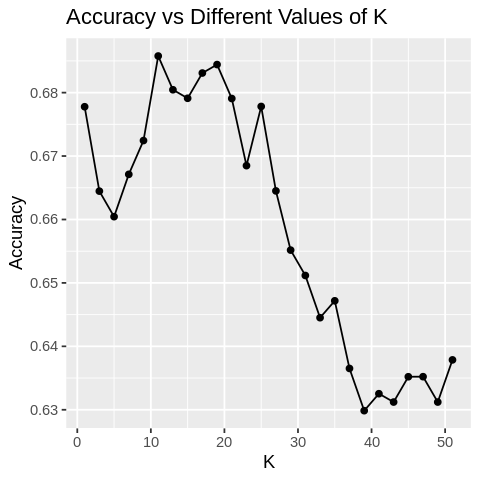

In [5]:
# Visualizing the different accuracies vs their k values
options(repr.plot.width=4, repr.plot.height=4)
accuracies <- choose_k$results %>%
                    select(k, Accuracy)
accuracies_plot <- ggplot(accuracies, aes(x=k, y=Accuracy)) +
                        geom_point() +
                        geom_line() +
                        labs(x="K", y="Accuracy", title="Accuracy vs Different Values of K")
accuracies_plot

In [6]:
# Training mock knn_model on k = 11, and displaying confusion matrix
knn_model <- train(x=X_train, y=Y_train, method="knn", tuneGrid=data.frame(k=11))
predictions <- predict(knn_model, X_test)
(model_quality <- confusionMatrix(data = predictions, reference = Y_test))


Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 78 66
        1  33 72
                                          
               Accuracy : 0.6024          
                 95% CI : (0.5387, 0.6637)
    No Information Rate : 0.5542          
    P-Value [Acc > NIR] : 0.070853        
                                          
                  Kappa : 0.2181          
                                          
 Mcnemar's Test P-Value : 0.001299        
                                          
            Sensitivity : 0.7027          
            Specificity : 0.5217          
         Pos Pred Value : 0.5417          
         Neg Pred Value : 0.6857          
             Prevalence : 0.4458          
         Detection Rate : 0.3133          
   Detection Prevalence : 0.5783          
      Balanced Accuracy : 0.6122          
                                          
       'Positive' Class : -1              
                                    

**Here we generate some basic summary statistics about the training data. How many values are missing, the number of observations in each class. We did not include the means of the predictors because all predictors were categorical and the mean would be meaningless. Instead, we included the relative distribution of predictors in a plot.**

In [7]:
# Make a table containing a count of observations in each class
summary_tidy <- training_data %>% gather(key = "Column", value = "Observation", na.rm = FALSE)
summary_tibble <- summary_tidy %>% group_by(Column,Observation) %>% summarize(count = n()) %>%
                  as_tibble()

# Set aside a separate table for the result observations because 
#           that's the main class balance we are concerned about
(summary_tbl_predictors <- summary_tibble %>% filter(Column != "Result") %>%
                         spread(key = Column,
                               value = count,
                               fill = 0))
summary_tbl_results <- summary_tibble %>% filter(Column == "Result") %>% select(-Column)
colnames(summary_tbl_results) <- c("Result","count")
summary_tbl_results

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

Observation,Abnormal_URL,Favicon,having_At_Symbol,Iframe,on_mouseover,popUpWindow,port,Prefix_Suffix,Redirect,SFH,Statistical_report,URL_Length
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-1,115,148,128,70,94,157,106,652,0,574,91,597
0,0,0,0,0,0,0,0,0,655,47,0,8
1,636,603,623,681,657,594,645,99,96,130,660,146


Result,count
<chr>,<int>
-1,334
1,417


As shown by the 2x2 above, the results are decently balanced, although the predictors are not. We will see that imbalance more clearly with the plot below.  

Also, notice here that if there were ANY "n/a" values in the dataset, na.rm = FALSE would have caught them. Instead, we see that there is actually NO missing data. Lucky us!

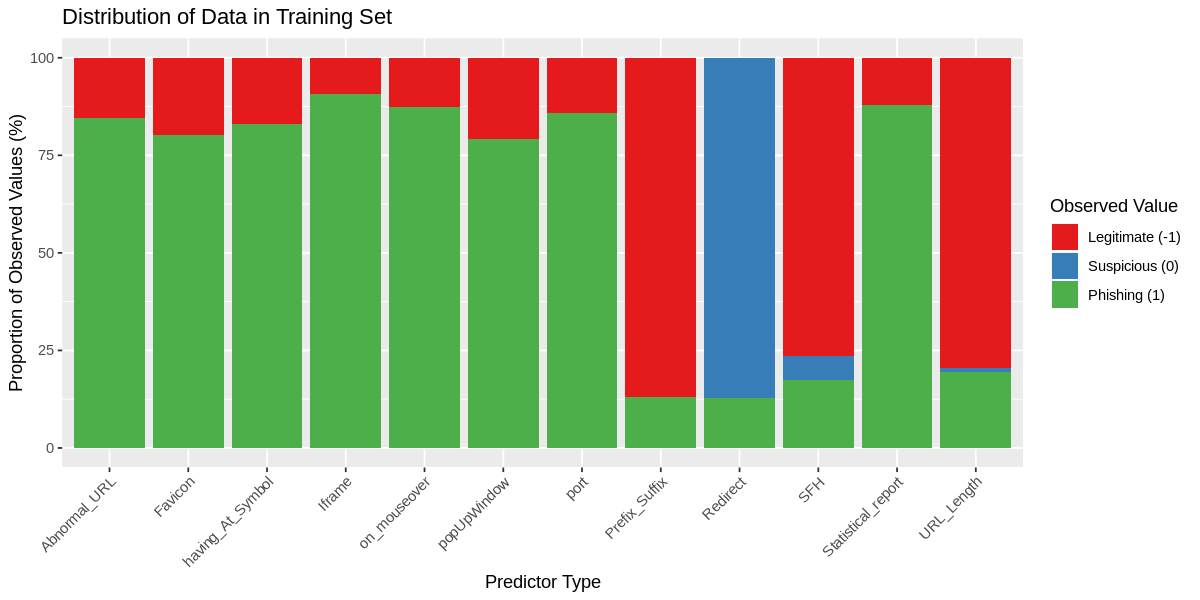

In [8]:
# plot distribution of predictor variables (since mean is useless when dealing with factors)
library(RColorBrewer)
options(repr.plot.width = 10, repr.plot.height = 5)
(predictor_dist_plot <- summary_tibble %>% filter(Column != "Result") %>%
                     arrange(desc(str_length(Observation))) %>%
                     ggplot(aes(x = Column, y = count/7.51, fill = Observation)) +
                     geom_bar(stat = "identity") +
                     scale_fill_brewer(palette = "Set1", 
                                        labels = c("Legitimate (-1)","Suspicious (0)","Phishing (1)")) +
                     labs(x = "Predictor Type", 
                          y = "Proportion of Observed Values (%)",
                         fill = "Observed Value") +
                     theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                     ggtitle("Distribution of Data in Training Set"))

Notice how almost none of the observations in any given column are found in a 1:1 ratio. This means that the average of such columns will be offset from 0, and indicates that the data requires serious scaling/normalizing.

**METHODS:**  
Thankfully, the raw data is tidy. Every row is an observation (website), every column is a variable, and every cell is its own value. That helps cut down on the preprocessing we need to do. From its native format, we have turned the results into factors and cut the data to a manageable size for our mock prediction model by selecting the subset (12) of predictors we thought would be most important, and heading the first 1000 observations/rows. 

For our full project, we plan to make two k-nn classification models: a bivariate model focused solely on the effects of Iframe and Redirection, and a more complex model looking at all 12 variables used in the mock analysis. Additionally, we will increase the number of observations in our real training data, and we will scale and normalize this data to account for the slight predictor imbalance.  

Along with the plots of accuracy vs. k with cross-validation and the confusion matrix of the testing of both models, we plan to visualize the bivariate model’s effectiveness via a scatterplot that shows the training data and a gradient indicating the model’s predictions, like the one found at the end of Chapter 6 in the textbook.



**EXPECTED OUTCOMES AND SIGNIFICANCE:**  
Firstly, we expect that both models will be fairly accurate at classifying websites (at least more than the 60% accuracy obtained in this mock analysis). Secondly, we expect that for the bivariate model, a positive observation for either IFrame, Redirect, or both variables will have a strong positive correlation with a ‘phishing’ classification. Finally, we expect that the complex (12 variable) model will be more accurate than the bivariate model.

Finding a classifier which accurately predicts whether a website is legitimate or intended for phishing could allow browsers and online services (e.g. Gmail, Google, etc.) to warn users from accidentally clicking on malicious links. In a world where the most common ‘hacker exploit’ is computer illiteracy and over-trusting users, a browser program which preemptively detects and warns users about risky links could be incredibly helpful in stopping most cyberattacks. 

With all that said, a 12 variable k-nn model could be rather slow in a practical application setting (browser). If we find a successful predictive model with 12 variables, it would incentivize research into a more performance-savvy model by cutting some variables, which would invite the follow-up question: among all the variables, which main few have the strongest statistical correlation to a website’s likelihood of being a phishing website?
